In [1]:
import os

def import_from_directory(directory, module_name):
    current_dir = os.getcwd()
    os.chdir(directory)
    module = __import__(module_name)
    os.chdir(current_dir)
    return module

test_base = import_from_directory('/home/jovyan/work/spectrum/notebooks/src', 'test_base')
model_base = import_from_directory('/home/jovyan/work/spectrum/notebooks/src', 'model_base')

2024-05-10 08:48:53.209580: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-10 08:48:53.249071: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-10 08:48:53.249112: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-10 08:48:53.250223: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-10 08:48:53.257065: I tensorflow/core/platform/cpu_feature_guar

In [2]:
SEED = 42
model_base.set_seed(SEED)

desired_directory = '/home/jovyan/work/spectrum/notebooks/'
os.chdir(desired_directory)

In [3]:
import pandas as pd

In [4]:
data_path = 'Data/test_data/humancohort_data.xlsx'
df_neg = pd.read_excel(data_path, sheet_name='negative', header = 4)[['Alignment ID','Average Mz', 'Metabolite name', 'Adduct type', 'MS/MS assigned','Ontology', 'INCHIKEY', 'SMILES', 'MS/MS spectrum']]
df_neg2 = df_neg[~df_neg['MS/MS spectrum'].isna()].reset_index(drop=True).\
    rename(columns={'Metabolite name':'Metabolitename', 'Alignment ID':'AlignmentID','Average Mz':'AverageMz', 'MS/MS spectrum':'MSMSspectrum', 'Adduct type':'Adducttype'})
df_neg2['datasetID'] = 1

In [5]:
df_neg3 = model_base.cal_df_sel_column(df_neg2)
df_neg_wide = model_base.cal_wide_df(df_neg3)

In [6]:
column_path = 'Data/model_data/neg/negmodelcolumn_all.pkl'
replacement_dict_path = 'Data/model_data/neg/neg_replacement_dict_all.pkl'
model_path = "models/neg_class_model"

replacement_dict, loaded_columns, loaded_model =\
        test_base.load_models(df_neg_wide, replacement_dict_path, column_path, model_path)

df_neg_wide2, columns_to_drop, replacement_dict_reversed, replacement_dict_reversed_df =\
        test_base.pred_data_adj(df_neg_wide, replacement_dict, loaded_columns)

df_test_predclass, df_test_predclass_v, df_neg_wide2, y_test_acc_, y_pred_test_max_ =\
        test_base.pred_data_by_model(df_neg_wide2, replacement_dict, replacement_dict_reversed, replacement_dict_reversed_df, loaded_model, columns_to_drop)
        

320/320 [==============================] - 2s 5ms/step


In [7]:
df_neg_wide_s = df_neg_wide[['Metabolitename','Ontology', 'AverageMz', 'Adducttype','ID']].reset_index().rename(columns={'index':'idx'})

df_test_predclass_v2 = df_neg_wide_s.merge(df_test_predclass_v, on='idx', how='inner')
df_test_predclass_v2 = df_test_predclass_v2.dropna()
df_test_predclass_v2 = df_test_predclass_v2[~df_test_predclass_v2['Metabolitename'].str.contains("w/o MS2")] #w/o MS2|low score

In [8]:
df_test_predclass_v2['pred_class_list'] = test_base.make_pred_class_list_column(df_test_predclass_v2)
df_test_predclass_v2['TF'] = df_test_predclass_v2.apply(test_base.check_ontology_in_pred_class, axis=1)

GLCAE

In [9]:
import matplotlib.pyplot as plt

In [54]:
def extract_x(row):
    return row['ID'].split('_')[1] if '_' in row['ID'] else None

def plot_spectrum(df_wide, Alignmnentid = '8864'):
    
    df_wide.index = df_wide.apply(extract_x, axis=1)
    columns_to_drop = [ 'Metabolitename','Ontology', 'AverageMz', 'Adducttype','ID', 'EOvalue',	'MCHvalue']
    df_wide = df_wide.drop(columns=columns_to_drop).astype(float)
    df1= pd.DataFrame(df_wide.loc[Alignmnentid]).reset_index().rename(columns={'index':'mz',Alignmnentid:'exp'}).astype('float')

    fig, axs = plt.subplots(1, 1, figsize=(4, 3))

    axs.plot(df1['mz'], df1['exp'], color='black')
    axs.set_xlabel('m/z', fontsize=12)
    axs.set_ylabel('Intensity', fontsize=12)
    axs.set_title('Alignment ID: ' + str(Alignmnentid), fontsize=12)
    axs.set_xlim(0, 1250)

    plt.show()

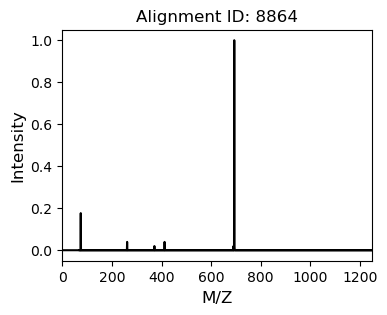

In [56]:
plot_spectrum(df_neg_wide, Alignmnentid = '8864')